In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

INFER_BASE = Path("/home/hep/an1522/dark_tridents_wspace/outputs/inference")

BAD_SCORE = -999999.9
BAD_PIXELS = -1

GRIDSIZE = 120   # adjust if slow (e.g. 80)
MINCNT = 1

# The one signal file you want (match by filename substring)
SIGNAL_WANT_SUBSTR = "dt_ratio_0.6_ma_0.05_pi0"

In [2]:
# Samples folders (each contains dirt/nu_overlay/offbeam score CSVs)
SAMPLES_FOLDERS = [
    "run1_samples_mpid",
    # "run1_samples_resnet18_bn",
    # "run1_samples_resnet18_gn",
    # "run1_samples_resnet34_bn",
    "run1_samples_resnet34_gn",
    # "run3_samples",
    # "run3_samples_resnet18_bn",
    # "run3_samples_resnet18_gn",
    # "run3_samples_resnet34_bn",
    # "run3_samples_resnet34_gn",
]

# Signal folders (each contains many dt_ratio/ma/pi0/eta score CSVs)
SIGNAL_FOLDERS = [
    "run1_signal_mpid",
    # "run1_signal_resnet18_bn",
    # "run1_signal_resnet18_gn",
    # "run1_signal_resnet34_bn",
    "run1_signal_resnet34_gn",
    # "run3_signal",
    # "run3_signal_resnet18_bn",
    # "run3_signal_resnet18_gn",
    # "run3_signal_resnet34_bn",
    # "run3_signal_resnet34_gn",
]

In [3]:
NEEDED = ["signal_score", "n_pixels"]

def _clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df["signal_score"] != BAD_SCORE) & (df["n_pixels"] != BAD_PIXELS) & (df["n_pixels"] >= 0)].copy()
    df["y_logpix"] = np.log10(df["n_pixels"].to_numpy(dtype=float) + 1.0)
    return df

def load_samples_split(folder: Path):
    """
    Returns dict: {"dirt": df, "nu_overlay": df, "offbeam": df}
    where df includes signal_score, n_pixels, y_logpix
    """
    files = sorted(folder.glob("*_scores.csv"))
    if not files:
        return {}

    buckets = {"dirt": [], "nu_overlay": [], "offbeam": []}

    for f in files:
        name = f.name.lower()

        # classify by filename
        if "dirt" in name:
            key = "dirt"
        elif "nu_overlay" in name:
            key = "nu_overlay"
        elif "offbeam" in name or "off_beam" in name:
            key = "offbeam"
        else:
            continue

        df = pd.read_csv(f, usecols=lambda c: c in NEEDED)
        if not set(NEEDED).issubset(df.columns):
            continue
        df = _clean_df(df[NEEDED].copy())
        buckets[key].append(df)

    out = {}
    for key, parts in buckets.items():
        if parts:
            out[key] = pd.concat(parts, ignore_index=True)
    return out

def load_signal_onefile(folder: Path, want_substr: str):
    """
    Loads only *_scores.csv containing want_substr in filename.
    Returns df or None.
    """
    files = sorted(folder.glob(f"*{want_substr}*_scores.csv"))
    if not files:
        return None

    # If multiple match (unlikely), concatenate them
    dfs = []
    for f in files:
        df = pd.read_csv(f, usecols=lambda c: c in NEEDED)
        if not set(NEEDED).issubset(df.columns):
            continue
        dfs.append(_clean_df(df[NEEDED].copy()))

    if not dfs:
        return None
    return pd.concat(dfs, ignore_index=True)

In [4]:
datasets = {}  # key -> df

# Samples: dirt/nu_overlay/offbeam per folder
for folder_name in SAMPLES_FOLDERS:
    folder = INFER_BASE / folder_name
    split = load_samples_split(folder)
    for sample_type, df in split.items():
        datasets[("samples", folder_name, sample_type)] = df
    print(f"[samples] {folder_name}: " +
          ", ".join(f"{k}={len(v):,}" for k, v in split.items()) if split else "NO DATA")

# Signal: only your one file per folder
for folder_name in SIGNAL_FOLDERS:
    folder = INFER_BASE / folder_name
    df = load_signal_onefile(folder, SIGNAL_WANT_SUBSTR)
    if df is not None and not df.empty:
        datasets[("signal", folder_name, SIGNAL_WANT_SUBSTR)] = df
        print(f"[signal] {folder_name}: rows={len(df):,}")
    else:
        print(f"[signal] {folder_name}: NO MATCH for {SIGNAL_WANT_SUBSTR}")

[samples] run1_samples_mpid: dirt=3,303, nu_overlay=13,769, offbeam=3,883
[samples] run1_samples_resnet34_gn: dirt=3,303, nu_overlay=13,769, offbeam=3,883
[signal] run1_signal_mpid: rows=4,218
[signal] run1_signal_resnet34_gn: rows=4,218


In [5]:
# If you want fixed x-range always:
x_min, x_max = 0.0, 1.0

# y-range from all plotted datasets
y_min = min(df["y_logpix"].min() for df in datasets.values())
y_max = max(df["y_logpix"].max() for df in datasets.values())
extent = (x_min, x_max, y_min, y_max)

# First pass: compute global max bin count so every plot shares same colorbar meaning
global_max_count = 1
for key, df in datasets.items():
    fig, ax = plt.subplots(figsize=(6, 4))
    hb = ax.hexbin(df["signal_score"], df["y_logpix"], gridsize=GRIDSIZE, extent=extent, mincnt=MINCNT)
    cmax = float(np.nanmax(hb.get_array())) if hb.get_array().size else 1.0
    global_max_count = max(global_max_count, cmax)
    plt.close(fig)

print("Global max bin count:", global_max_count)
shared_norm = LogNorm(vmin=1, vmax=global_max_count)

Global max bin count: 495.0


In [6]:
OUT_DIR = Path("/home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels")
OUT_DIR.mkdir(parents=True, exist_ok=True)

import re

def pretty_title(s: str) -> str:
    """
    Convert things like:
      'run1_samples_resnet34_gn' -> 'Run 1 Samples (ResNet34 GN)'
      'run1_signal'             -> 'Run 1 Signal'
      'mpid'                    -> 'MPID'
      'signal_score'            -> 'Signal Score'
    Also removes underscores and tidies spaces.
    """
    if s is None:
        return ""

    t = str(s).strip()

    # common field names
    t = t.replace("signal_score", "Signal Score")
    t = t.replace("n_pixels", "N Pixels")
    t = t.replace("mpid", "MPID").replace("MPId", "MPID").replace("Mpid", "MPID")

    # run1/run3 -> Run 1 / Run 3
    t = re.sub(r"\brun\s*([13])\b", r"Run \1", t, flags=re.IGNORECASE)
    t = re.sub(r"\brun([13])\b", r"Run \1", t, flags=re.IGNORECASE)

    # samples/signal
    t = re.sub(r"\bsamples\b", "Samples", t, flags=re.IGNORECASE)
    t = re.sub(r"\bsignal\b", "Signal", t, flags=re.IGNORECASE)

    # ResNet variants
    # resnet18_bn -> ResNet18 BN, resnet34_gn -> ResNet34 GN
    t = re.sub(r"\bresnet\s*(\d+)\s*[_ ]?(bn|gn)\b",
               lambda m: f"ResNet{m.group(1)} {m.group(2).upper()}",
               t, flags=re.IGNORECASE)
    t = re.sub(r"\bresnet\s*(\d+)\b",
               lambda m: f"ResNet{m.group(1)}",
               t, flags=re.IGNORECASE)
    t = t.replace("Resnet", "ResNet")

    # underscores -> spaces + compress whitespace
    t = t.replace("_", " ")
    t = re.sub(r"\s+", " ", t).strip()

    return t


def safe_filename_pretty(s: str) -> str:
    """
    Filename-safe, also no underscores. Uses hyphens between words.
    """
    t = pretty_title(s)
    t = re.sub(r"[^\w\s\-\.\(\)]", "", t)   # keep letters/numbers/space/-/./()
    t = t.strip().replace(" ", "-")
    t = re.sub(r"-{2,}", "-", t)
    return t


def plot_hexbin(title: str, df: pd.DataFrame, save_prefix: str = None):
    fig, ax = plt.subplots(figsize=(8, 6))

    hb = ax.hexbin(
        df["signal_score"], df["y_logpix"],
        gridsize=GRIDSIZE,
        extent=extent,
        mincnt=MINCNT,
        norm=shared_norm
    )

    ax.set_title(pretty_title(title))

    # LaTeX labels (capitalised, no underscores)
    ax.set_xlabel(r"$\mathrm{Signal\ Score}$")
    ax.set_ylabel(r"$\log_{10}\!\left(N_{\mathrm{pixels}} + 1\right)$")
    ax.grid(True, alpha=0.3)

    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label(r"$N_{\mathrm{events}}\ \mathrm{per\ hexbin}$ (log scale)")

    fig.tight_layout()

    if save_prefix:
        out_path = OUT_DIR / f"{safe_filename_pretty(save_prefix)}.png"
        fig.savefig(out_path, dpi=200)
        print("saved:", out_path)

    plt.show()

In [7]:
import re

def pretty_sample_type(s: str) -> str:
    # expects: "dirt", "nu_overlay", "off_beam"
    s = str(s).strip().lower()
    return {
        "dirt": "Dirt",
        "nu_overlay": r"$\nu$ Overlay",
        "off_beam": "Off-beam",
        "offbeam": "Off-beam",
    }.get(s, s.replace("_", " ").title())

def pretty_signal_tag(tag: str) -> str:
    """
    expects: "ratio_0.6_ma_0.05_pi0" (or similar)
    -> "Ratio 0.6, m_A 0.05, π⁰"
    """
    t = str(tag).strip().lower()

    # pull numbers if present
    m_ratio = re.search(r"ratio[_= ]?([0-9]*\.?[0-9]+)", t)
    m_ma    = re.search(r"(?:ma|m_a)[_= ]?([0-9]*\.?[0-9]+)", t)

    parts = []
    if m_ratio:
        parts.append(rf"$\mathrm{{Ratio}}={m_ratio.group(1)}$")
    if m_ma:
        parts.append(f"$m_{{A}}={m_ma.group(1)}$")

    if "pi0" in t or "pi_0" in t:
        parts.append(r"$\mathrm{{Dmode}}=\pi^{0}$")
    elif "eta" in t:
        parts.append(r"$\eta$")

    return ", ".join(parts) if parts else tag.replace("_", " ").title()

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-MPID-dirt.png


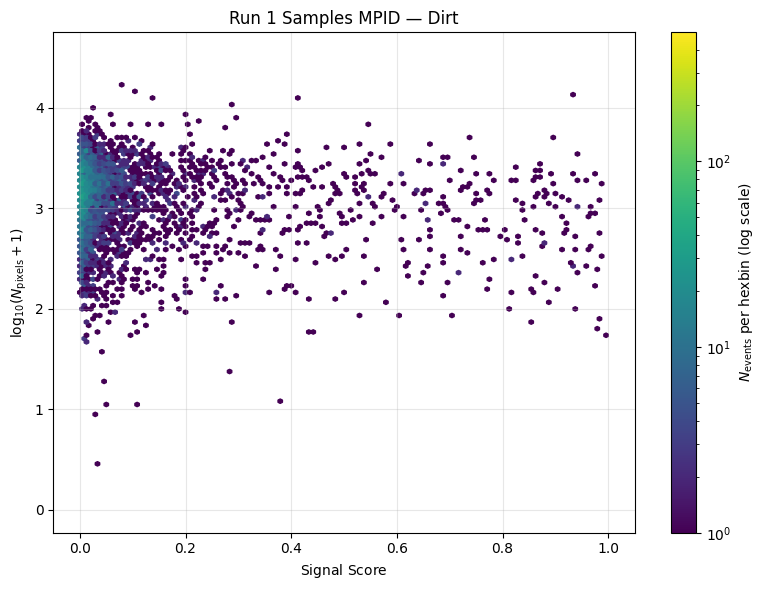

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-MPID-nu-overlay.png


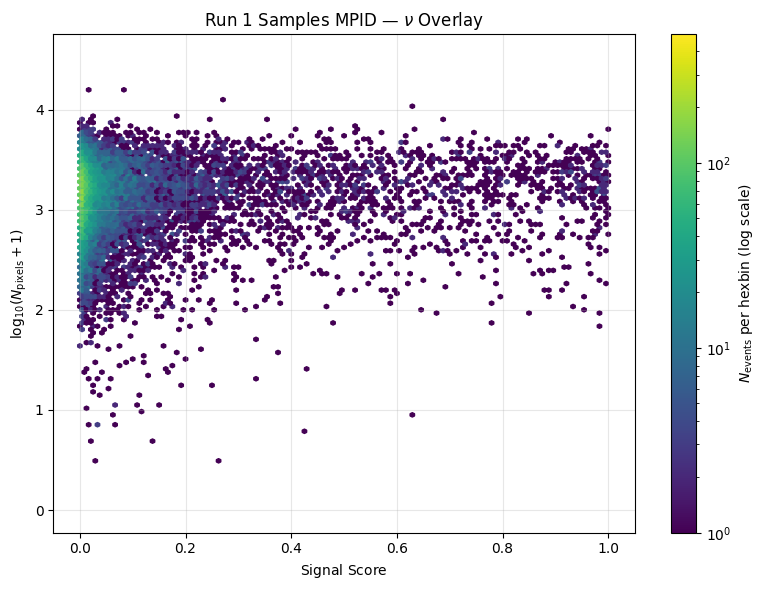

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-MPID-offbeam.png


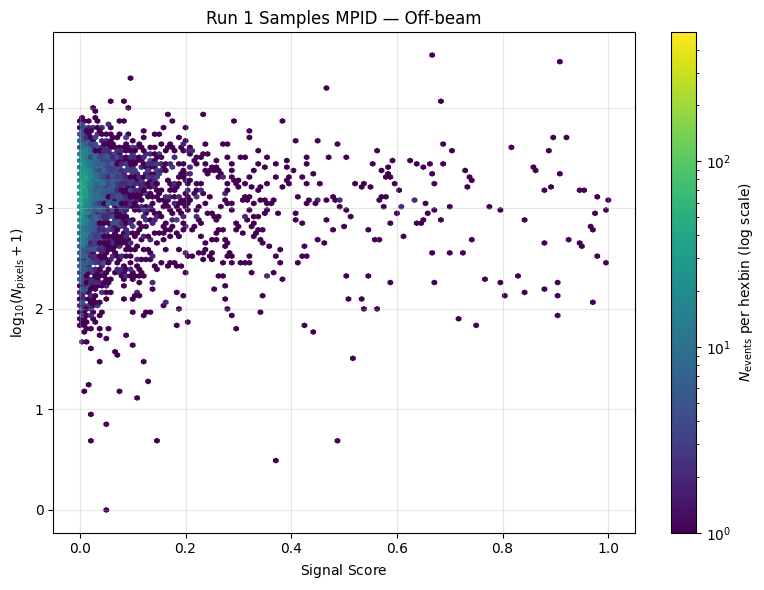

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-resnet34-gn-dirt.png


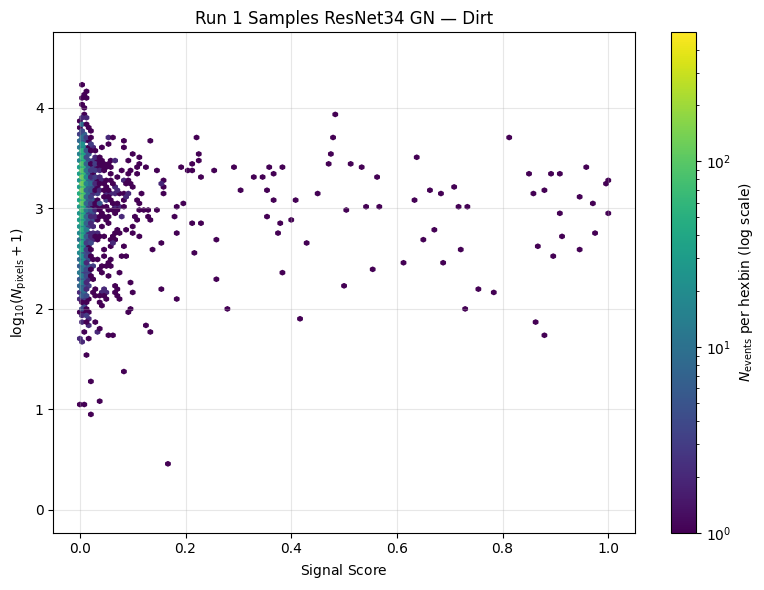

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-resnet34-gn-nu-overlay.png


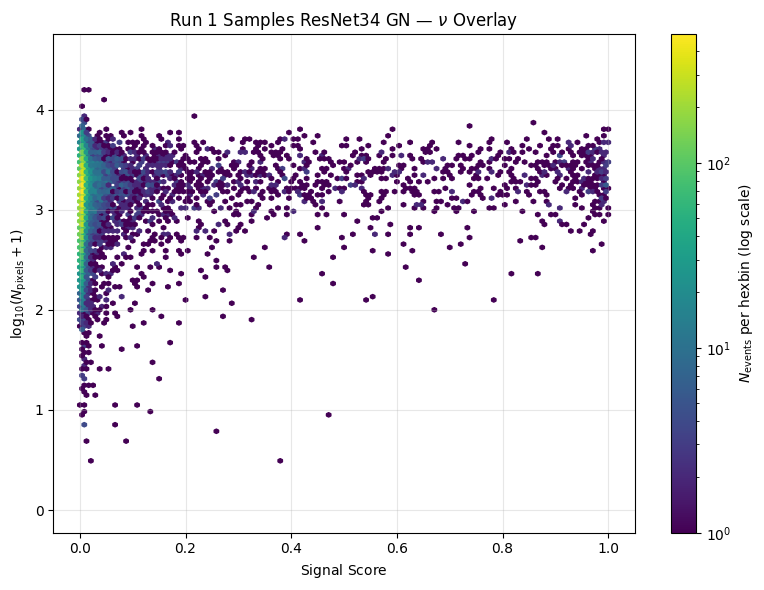

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-samples-resnet34-gn-offbeam.png


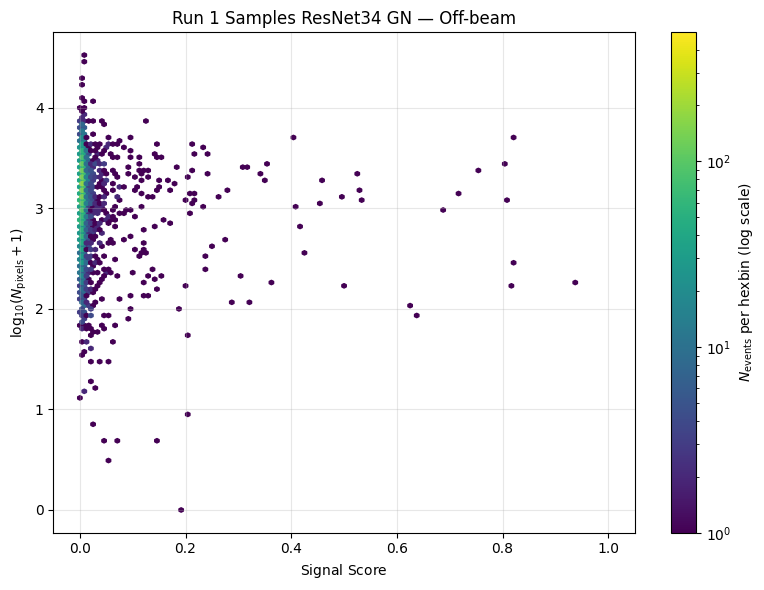

In [8]:
for (kind, folder_name, sample_type), df in datasets.items():
    if kind != "samples":
        continue

    title = f"{pretty_title(folder_name)} — {pretty_sample_type(sample_type)}"
    save = f"hexbin__{folder_name}__{sample_type}"

    plot_hexbin(title, df, save_prefix=save)


saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-signal-MPID-dt-ratio-0.6-ma-0.05-pi0.png


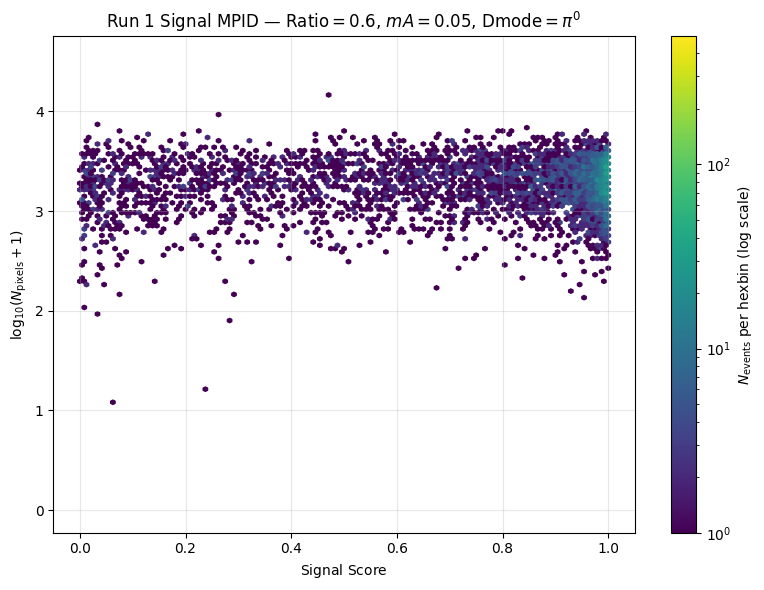

saved: /home/hep/an1522/dark_tridents_wspace/outputs/signal_score_vs_n_pixels/hexbin-run1-signal-resnet34-gn-dt-ratio-0.6-ma-0.05-pi0.png


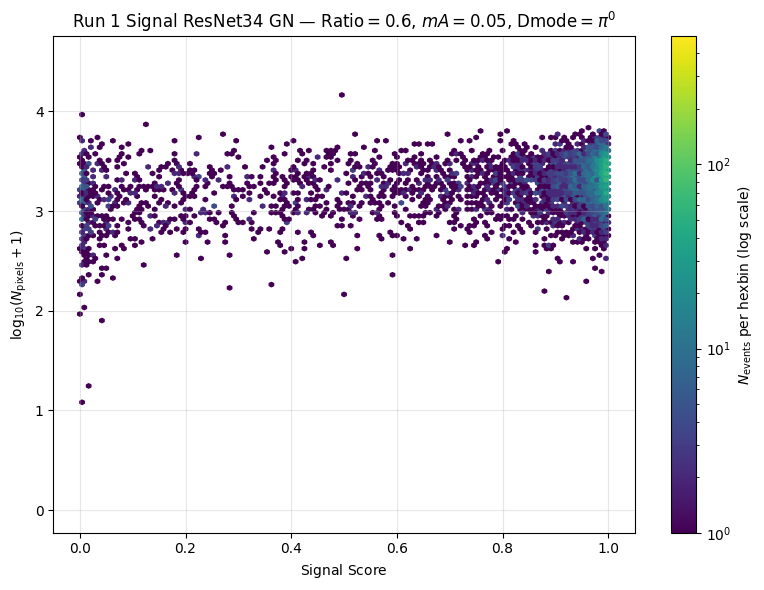

In [9]:
for (kind, folder_name, tag), df in datasets.items():
    if kind != "signal":
        continue

    title = f"{pretty_title(folder_name)} — {pretty_signal_tag(tag)}"
    save = f"hexbin__{folder_name}__{sample_type}"

    plot_hexbin(title, df, save_prefix=save)

In [10]:
# Show row counts by (folder, type)
rows = []
for (kind, folder_name, t), df in datasets.items():
    rows.append({"kind": kind, "folder": folder_name, "type": t, "rows": len(df)})
pd.DataFrame(rows).sort_values(["kind","folder","type"])

,kind,folder,type,rows
0,samples,run1_samples_mpid,dirt,3303
1,samples,run1_samples_mpid,nu_overlay,13769
2,samples,run1_samples_mpid,offbeam,3883
3,samples,run1_samples_resnet34_gn,dirt,3303
4,samples,run1_samples_resnet34_gn,nu_overlay,13769
5,samples,run1_samples_resnet34_gn,offbeam,3883
6,signal,run1_signal_mpid,dt_ratio_0.6_ma_0.05_pi0,4218
7,signal,run1_signal_resnet34_gn,dt_ratio_0.6_ma_0.05_pi0,4218
